In [1]:
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from torch_geometric.utils import to_networkx, negative_sampling, to_dense_adj
from torch_geometric.datasets import KarateClub

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
data = KarateClub()[0]

In [3]:
data

Data(edge_index=[2, 156], train_mask=[34], x=[34, 34], y=[34])

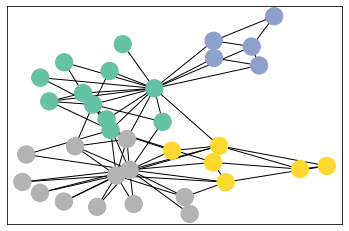

In [4]:
G = to_networkx(data, to_undirected=True)

nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,node_color=data.y, cmap="Set2")

In [5]:
# no features, just node ids

data.x = torch.arange(data.num_nodes) # node idx

In [6]:
from torch_geometric.nn.models import GAE

In [7]:
class LookupEncoder(nn.Module):
    
    def __init__(self, num_nodes, embedding_dim):
        
        super().__init__()
        
        self.emb = nn.Embedding(num_nodes, embedding_dim)
        
    def forward(self, x, edge_index):
        
        # encoder takes as input x and edge_index for GAE
        
        return self.emb(x)

In [8]:
class ShallowGAE(nn.Module):
    
    def __init__(self, num_nodes, embedding_dim):

        super().__init__()

        # GAE decoder is dot product by default
        self.gae = GAE(encoder=LookupEncoder(num_nodes, embedding_dim), decoder=None)

    def get_embeddings(self):

        return self.gae.encoder.emb.weight.data

    def visualize(self):

        """visulize embeddings with PCA"""

        node_embeddings = self.get_embeddings()

        node_cmp = PCA(n_components=2).fit_transform(node_embeddings)

        y = data.y.numpy()

        plt.scatter(node_cmp[:, 0], node_cmp[:, 1], s=140, c=y, cmap="Set2")

        plt.show()

    def train_model(self, x, edge_index, n_steps, opt):

        """train model given x, edge_index, n_steps and opt"""

        for i in tqdm(range(n_steps)):

            z = self.gae.encode(x, edge_index) # encode nodes

            loss = self.gae.recon_loss(z, edge_index) # compute loss

            loss.backward()

            opt.step()

            opt.zero_grad()

            if i % 1000 == 0:

                print(f'epoch={i}')

                self.visualize()

In [9]:
model = ShallowGAE(data.num_nodes, 16)

opt = torch.optim.SGD(model.parameters(), lr=0.5, weight_decay=0.001)

  0%|          | 0/10000 [00:00<?, ?it/s]

epoch=0


/home/urchade.zaratiana/.local/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


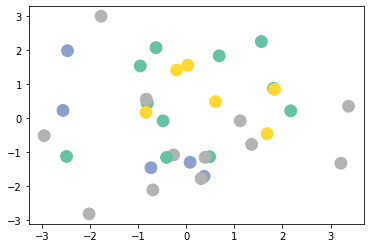

 10%|▉         | 996/10000 [00:01<00:15, 564.18it/s]

epoch=1000


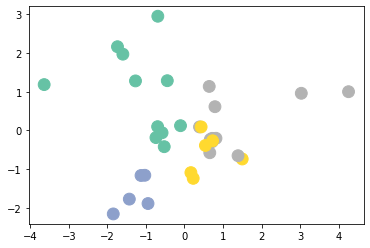

 20%|█▉        | 1971/10000 [00:03<00:14, 555.51it/s]

epoch=2000


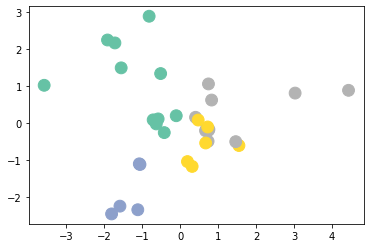

 29%|██▉       | 2945/10000 [00:05<00:12, 570.43it/s]

epoch=3000


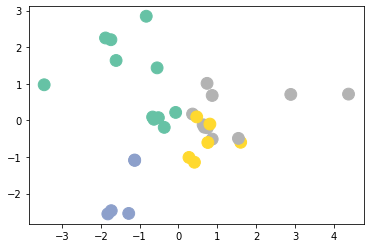

 40%|███▉      | 3968/10000 [00:07<00:09, 632.86it/s]

epoch=4000


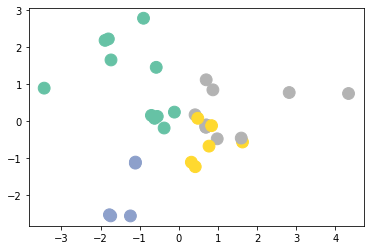

 50%|████▉     | 4982/10000 [00:09<00:07, 630.97it/s]

epoch=5000


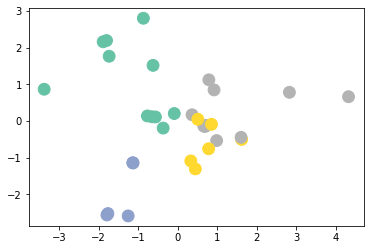

 60%|█████▉    | 5976/10000 [00:10<00:07, 543.91it/s]

epoch=6000


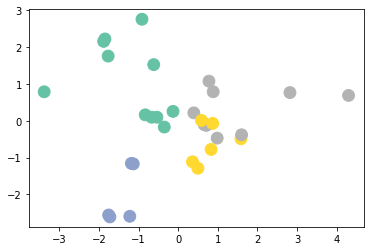

 70%|██████▉   | 6975/10000 [00:12<00:04, 624.07it/s]

epoch=7000


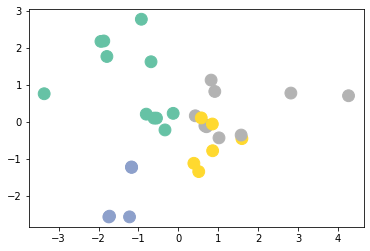

 80%|███████▉  | 7964/10000 [00:14<00:03, 561.92it/s]

epoch=8000


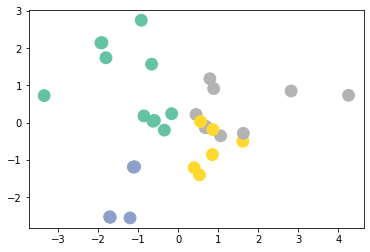

 90%|████████▉ | 8977/10000 [00:16<00:01, 564.87it/s]

epoch=9000


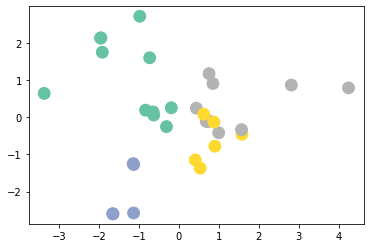

 95%|█████████▍| 9472/10000 [00:17<00:01, 494.66it/s]

In [ ]:
model.train_model(data.x, data.edge_index, 10000, opt)